In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# Loading datasets
customers = pd.read_csv("/Users/apple/Desktop/Internship/Customers.csv")
products = pd.read_csv("/Users/apple/Desktop/Internship/Products.csv")
transactions = pd.read_csv("/Users/apple/Desktop/Internship/Transactions.csv")

In [24]:
# Preview of the datasets to confirm they are loaded correctly
print("Customers Dataset:\n", customers.head())
print("\nProducts Dataset:\n", products.head())
print("\nTransactions Dataset:\n", transactions.head())

Customers Dataset:
   CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products Dataset:
   ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Transactions Dataset:
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166

In [25]:
# Merging Customers and Transactions datasets
merged_data = transactions.merge(customers, on='CustomerID')


In [26]:
# Creating features for customer segmentation
customer_segmentation = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',   # Total spending by the customer
    'Quantity': 'sum',     # Total quantity purchased
    'TransactionID': 'count'  # Number of transactions made
}).rename(columns={
    'TotalValue': 'TotalSpending',
    'Quantity': 'TotalQuantity',
    'TransactionID': 'TransactionCount'
}).reset_index()




In [27]:
# Add customer profile information
customer_segmentation = customer_segmentation.merge(customers, on='CustomerID')

In [28]:
# Dropping unnecessary columns
customer_segmentation.drop(columns=['CustomerID', 'CustomerName', 'SignupDate'], inplace=True)


In [29]:
# Converting categorical columns to dummy variables
customer_segmentation = pd.get_dummies(customer_segmentation, columns=['Region'], drop_first=True)


In [30]:
# Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_segmentation)

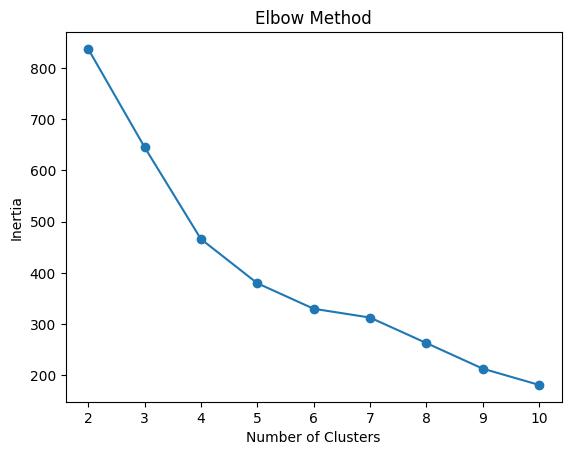

In [31]:
# Using the Elbow Method to find the optimal number of clusters
inertia = []
k_range = range(2, 11)  # From 2 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


In [32]:
# Setting the optimal number of clusters
optimal_clusters = 4

# Applying KMeans clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_segmentation['Cluster'] = kmeans.fit_predict(scaled_data)

# Checking cluster counts
print(customer_segmentation['Cluster'].value_counts())


Cluster
1    62
0    52
3    46
2    39
Name: count, dtype: int64


In [33]:
# Calculating Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_data, customer_segmentation['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 0.9880667545355788


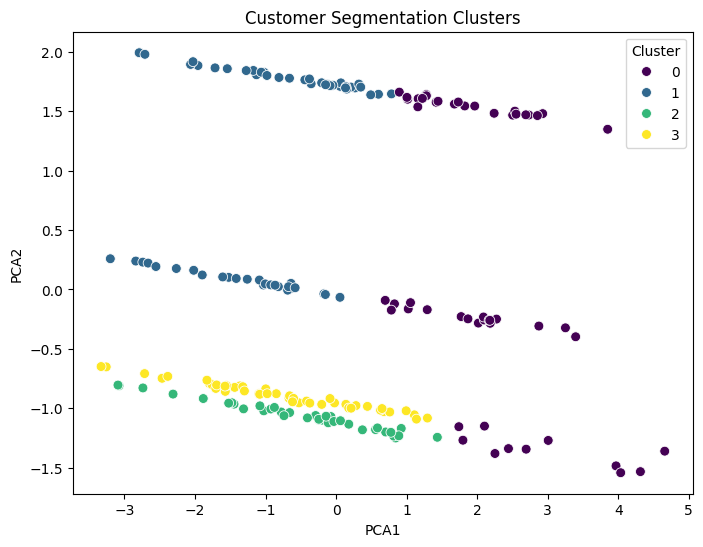

In [34]:
# Visualizing clusters using the first two principal components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Add PCA results to the dataset
customer_segmentation['PCA1'] = pca_data[:, 0]
customer_segmentation['PCA2'] = pca_data[:, 1]

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_segmentation, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=50)
plt.title('Customer Segmentation Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()


In [35]:
# Summarizing cluster characteristics
cluster_summary = customer_segmentation.groupby('Cluster').mean()
print(cluster_summary)


         TotalSpending  TotalQuantity  TransactionCount  Region_Europe  \
Cluster                                                                  
0          5636.609231      20.557692          7.557692       0.076923   
1          2410.626290       8.838710          3.677419       0.000000   
2          2784.740000      10.871795          4.589744       0.000000   
3          3018.004130      10.782609          4.347826       1.000000   

         Region_North America  Region_South America      PCA1      PCA2  
Cluster                                                                  
0                    0.134615              0.442308  2.131726  0.316627  
1                    0.000000              0.580645 -0.952820  1.069105  
2                    1.000000              0.000000 -0.480598 -1.064620  
3                    0.000000              0.000000 -0.718077 -0.896281  
